# Reprendre en main le jeu de données de Antônio H. Ribeiro (L'étude des signaux d'ECG pour prevoir des risques cardiaques)

## 1 - Introduction :

Avant de rentrer dans le vif du sujet on doit savoir la définition de trois termes scientifiques qui vont être la clé de cet article : 

1.	Electrocardiogram (ECG) :

    *L'électrocardiographie est une représentation graphique de l'activité électrique du cœur. Cette activité électrique est liée aux variations de potentiel électrique des cellules spécialisées dans la contraction (myocytes) et des cellules spécialisées dans l'automatisme et la conduction des influx. Elle est recueillie par des électrodes à la surface de la peau.
    
    *L’électrocardiogramme reste un outil essentiel et majeur dans le diagnostic des maladies cardiovasculaire.
    
    
2.	Deep neural network (DNN) :

    *the deep neural network ou l’apprentissage profond en français est un ensemble de méthodes d'apprentissage automatique tentant de modéliser avec un haut niveau d’abstraction des données grâce à des architectures articulées de différentes transformations non linéaires.
    
    *Les réseaux de neurones profonds (DNN) ont récemment obtenu un succès frappant dans des tâches telles que la classification d'images et la reconnaissance vocale, et les attentes sont grandes quant à la manière dont cette technologie peut améliorer les soins de santé et la pratique clinique. Jusqu'à présent, les applications les plus réussies utilisaient une configuration d'apprentissage supervisé pour automatiser le diagnostic des examens.
    

3.  L’apprentissage supervisé :

	L’apprentissage est dit supervisé lorsque les données qui entrent dans le processus sont déjà catégorisées et que les algorithmes doivent s’en servir pour prédire un résultat en vue de pouvoir le faire plus tard lorsque les données ne seront plus catégorisées. On peut par exemple donner au système une liste de profils clients contenant des habitudes d’achat, et expliquer à l’algorithme lesquels sont des clients habituels et lesquels sont des clients occasionnels. Une fois l’apprentissage terminé, l’algorithme devra pouvoir déterminer tout seul à partir d’un profil client à quelle catégorie celui-ci appartient.
    
Nous présentons ici un réseau de neuronnes formé d’un ensemble de données avec plus de 2 millions d’examens labellisés et qui a mené à des résultats très satisfaisantes et qui dépasse même les résultats des médecins résidents en cardiologie.

Dans cet article, nous cherchons à montrer l’efficacité du réseau neurones qu'on a nommé S12L-ECG et qui permet de classer six types d’anomalies:

* 1st degree AV block (1dAVb)
* Right Bundle Branch Block (RBBB)
* Left Bundle Branch Block (LBBB)
* Sinus Bradycardia (SB)
* Atrial Fibrillation (AF)
* Sinus Tachycardia (ST)


## 2 - Data :

Afin de tester le modèle on a utilisé une base de données composée de 827 tracés de patients distincts annotés par trois cardiologues différents ayant une expérience en électrocardiographie. Cette Base de Données est représentée sous la forme suivante : 
![alt tag](https://user-images.githubusercontent.com/70271267/91366964-7c882880-e805-11ea-9e64-1d1ccbdbdd6b.png"Base de données")

Les S1L,S2L,…S12L représentent les signaux. 

Notre ensemble de données est donc de la forme (827,4096,12) , et on peut vérifier ça avec le code qui suit :

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
f = h5py.File('PFE/data/ecg_tracings.hdf5', "r")
data = list(f['tracings'])
#print(data)
print("La taille du dataset est de :", np.shape(data))

La taille du dataset est de : (827, 4096, 12)


## 3 - Méthodes :
Avant d'entraîner le réseau neurones on suit le cheminement suivant :
![alt text](DV1.png "Méthodes")

### Acquisition de jeux de données :
Tous les S12L-ECGs analysés dans cette étude ont été obtenue par le Telehealth Network of Minas Gerais (TNMG) qui est un système public de télésanté qui aide plusieurs municipalités de l'état de Minas Gerais-Brezil.
La durée d'un enregistrement ECG est entre 7 et 10 secondes échantillonnés sur des fréquences allant de 300 à 600 Hz.

Un logiciel mis en disposition qui permet d'enregistrer les résultats des enregistrement ECG et de l'envoyer au centre d'analyse TNMG avec le dossier médical du patient. une fois que ces informations arrivent au centre, un spécialiste analysera le dossier et fournira un rapport détaillé.

Depuis Avril 2018, toutes les informations cliniques (les tracés d'ECG et les rapports des Cardiologue) ont été stockés dans une BDD. une récente étude Clinical Outcomes in Digital Electrocardiology (CODE) a été établi pour optimiser et normaliser cette BDD pour les études cliniques être épidémiologiques.

Dans cette étude, l'ensemble des données obtenues entre 2010 et 2016 ont été utilisés dans le Training et Validation set, et d'Avril à Septembre 2018, dans le test set. 
### Labeling training data from text report :
L'étiquette du texte est obtenu grâce à la procédure suivante :
 * Supprimer les mots vides ( Un mot non significatif figurant dans un texte ) et générer les n-grams( Il s’agit d’une séquence de taille n, piochée dans une séquence de taille plus grande que n ) du rapport médical.
 * Appliquer le Lazy Associative Classifier (LAC) à ces n-grams.
 * Utiliser le résultat LAC dans un classificateur basé sur des règles prédéfini.
 
Grâce à cette classification, on a pu récupéré la bonne étiquette médicale avec de bon résultats. Un score macro-F1 supérieur à 0,73 pour les 6 anomalies.
### Annotation de Training and Validation set :
Pour annoter le Training-Validation dataset, nous avons utilisé:

  * Les relevés Uni-G et les codes du Minnesota obtenus par l'analyse automatique Uni-G.
  
  * Les mesures automatiques fournies par le logiciel Uni-G.
  
  * Les étiquettes de texte extraites des rapports d'expert.
 
Le diagnostic automatique, le diagnostic médical ainsi que les étiquettes du texte sont sujet à des erreurs qua ça soit lié à une mauvaise classification, à des erreurs d'expert ou à la méthodologique d'étiquetage.

Afin d'améliorer la qualité du dataset, on combine l'annotation des experts avec l'analyse automatique. On suit la procedure suivante pour obtenir la bonne annotation :

1. (a) On accepte un diagnostic si les experts et la déclaration Uni-G ont indiqué tous les deux la présence la même anomalie.

   (b) On refuse un diagnostic si seulemnt un seul classifieur automatique a détecté une anomalie alors que les docteurs et l'autre classifieur non.
 
Il existe aussi deux scénarios possible pour accepter ou refuser un diagnostic :

 * Les deux classifieurs indiquent la présence d'une anomalie, mais l'expert non.
 
 * L'expert indique la présence d'une anomalie, alors que les deux classifieur ne détectent rien.
 
2. On utilise ensuite les règles suivantes pour rejetter certains des diagnostics restants :
 
 * Les diagnostics de ST où les fréquences cardiaques étaient inférieures à 100 ont été rejetés.
 
 * Les diagnostics de SB où les fréquences cardiaques étaient supérieures à 50 ont été rejetés.
 
 * Les diagnostics de LBBB ou RBBB où la durée de l'intervalle QRS était inférieure à 115 ms ont été rejetés.
 
 * Les diagnostics de 1dAVb où la durée de l'intervalle PR était inférieure à 190 ms ont aussi été rejetés.
 
3. Ensuite, à l'aide de l'analyse de sensibilité, on a trouvé des règles qui pourront accepter des diagnostics :

 * Pour RBBB, d1AVb, SB et ST, nous avons accepté tous les diagnostics médicaux.
 
 * Pour la AF, nous avons exigé non seulement que l'examen soit considéré comme vrai par les médecins, mais également que l'écart-type des intervalles NN soit supérieur à 646. Plusieurs diagnostics ont été acceptés grâce à cette règle.
 
Selon l'analyse de sensibilité, le taux de faux positifs est devenu inférieur à 3% du nombre total d'examens.
 
4. Après ce processus, il nous restait quelques examens où les diagnostics correspondants ne pouvaient être ni acceptés ni rejetés, ces derniers ont été traités manuellement par des étudiants sous la présence d'un expert.

Il convient de souligner que les informations des rapports médicaux précédents et les mesures automatiques ne rentrent pas dans l'entraînement de notre réseau neurones.

### Annotation du Test set :
L'ensemble de données utilisé pour tester le DNN a également été obtenu à partir du système ECG de TNMG. Il a été annoté indépendamment par deux cardiologues certifiés ayant une expérience en électrocardiographie et ils ont gardé les parties où ils étaient en accord, et ils ont fait appel à un troisième cardiologue certifié dans le cas contraire.

## 4 - Méthodes :

On a utilisé un réseau de neurones convolutif qui fonctionne de la même manière qu’un RN (Residual Network) couramment utilisée pour les images que nous avons ici adaptée aux signaux unidimensionnels. L’architecture du DNN est la suivante : 

![alt text](DNN.png "DNN")

Comme on peut le voir sur la photo le réseau se compose de :

 * 1 couche convolutive (Conv) qui est suivi par une normalisation de type BN et une fonction d’activation de type ReLU.
 
 * 4 blocs résiduels (ResBlk) avec deux couches convolutives par bloc.
 
 * Une dernière couche connectée (Dense) avec une fonction d’activation de type Sigmoide.

On peut vérifier ces composantes aussi via le codes suivant :

In [19]:
#Model :
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.layers import (Input, Conv1D, MaxPooling1D, Dropout,
                          BatchNormalization, Activation, Add,
                          Flatten, Dense)
from keras.models import Model
import numpy as np


class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, otional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_rate: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_rate=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = dropout_rate
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1].value
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2].value
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


# ----- Model ----- #
kernel_size = 16
kernel_initializer = 'he_normal'
signal = Input(shape=(4096, 12), dtype=np.float32, name='signal')
age_range = Input(shape=(6,), dtype=np.float32, name='age_range')
is_male = Input(shape=(1,), dtype=np.float32, name='is_male')
x = signal
x = Conv1D(64, kernel_size, padding='same', use_bias=False,
           kernel_initializer=kernel_initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, x])
x, y = ResidualUnit(256, 196, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, y])
x, y = ResidualUnit(64, 256, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, y])
x, _ = ResidualUnit(16, 320, kernel_size=kernel_size,kernel_initializer=kernel_initializer)([x, y])
x = Flatten()(x)
diagn = Dense(6, activation='sigmoid', kernel_initializer=kernel_initializer)(x)
model = Model(signal, diagn)
# ----------------- #


if __name__ == "__main__":
    model.summary()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             (None, 4096, 12)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4096, 64)     12288       signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4096, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 4096, 64)     0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Les paramètres du DNN ont été appris à l’aide du training set et les choix de conception ont été faits afin de maximiser les performances sur le validation set.

## 5 - Codes :

In [21]:
#test requirements :
import numpy
print('Numpy version is :',numpy.__version__)
import pandas 
print('Pandas version is :', pandas.__version__)
import keras 
print('Keras vertsion is :', keras.__version__)
import tensorflow 
print('Tenserflow version is :',tensorflow.__version__)
import h5py 
print('h5py version is :', h5py.__version__)
#import xmljson
#print('xmljson version is :',xmljson.__version__)
import scipy
print('Scipy version is :', scipy.__version__)
import sklearn 
print('Scikit-learn version is :' ,sklearn.__version__)
import tqdm 
print('tqdm version is :' ,tqdm.__version__)
import xarray 
print('xarray version is :', xarray.__version__)
import seaborn 
print('seaborn version is :',seaborn.__version__)

Numpy version is : 1.18.1
Pandas version is : 1.0.1
Keras vertsion is : 2.3.1
Tenserflow version is : 2.0.0
h5py version is : 2.10.0
Scipy version is : 1.4.1
Scikit-learn version is : 0.22.1
tqdm version is : 4.42.1
xarray version is : 0.15.1
seaborn version is : 0.10.0


In [23]:
import sys     #Fait a des fonctions propres à des systèmes.
import tensorflow.compat.v1 as tf  #Fait appel à la binliothèque Tensorflow Version 1.xx
#tf.disable_v2_behavior()
from keras.optimizers import Adam #On fait appel à Adam optimizer qui est une méthode de descente de gradient stochastqiue  sur une estimation des moments du premier et second ordre
from keras.callbacks import (ModelCheckpoint,
                             TensorBoard, ReduceLROnPlateau,
                             CSVLogger, EarlyStopping)
from keras.backend.tensorflow_backend import set_session
#from model import model
import argparse #C'est un module d'analyse de ligne de commande recommandé dans la bibliothèque standard de Python
from keras.utils import HDF5Matrix
import pandas as pd
import h5py
import numpy as np

if __name__ == "__main__":
    # Get data and train
    class args:
        path_to_hdf5 = 'PFE/data/ecg_tracings.hdf5'
        path_to_csv  = 'PFE/data/annotations/cardiologist1.csv'
        val_split    = 0.02
        dataset_name = 'tracings'
    #parser = argparse.ArgumentParser(description='Train neural network.')
    #parser.add_argument('path_to_hdf5', type=str,
    #                    help='path to hdf5 file containing tracings')
    #parser.add_argument('path_to_csv', type=str,
    #                    help='path to csv file containing annotations')
    #parser.add_argument('--val_split', type=float, default=0.02,
    #                    help='number between 0 and 1 determining how much of'
    #                         ' the data is to be used for validation. The remaining '
    #                         'is used for validation. Default: 0.02')
    #parser.add_argument('--dataset_name', type=str, default='tracings',
    #                    help='name of the hdf5 dataset containing tracings')
    #args = parser.parse_args()
    # Optimization settings
    loss = 'binary_crossentropy'
    lr = 0.001
    batch_size = 64
    opt = Adam(lr)
    callbacks = [ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=7,
                                   min_lr=lr / 100),
                 EarlyStopping(patience=9,  # Patience should be larger than the one in ReduceLROnPlateau
                               min_delta=0.00001)]
    # Set session and compile model
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.keras.backend.set_session(tf.Session(config=config))
    # If you are continuing an interrupted section, uncomment line bellow:
    #   model = keras.models.load_model(PATH_TO_PREV_MODEL, compile=False)
    model.compile(loss=loss, optimizer=opt)
    # Get annotations
    y = pd.read_csv(args.path_to_csv).values
    # Get tracings
    f = h5py.File(args.path_to_hdf5, "r")
    x = f[args.dataset_name]
    print(x)

    # Create log
    callbacks += [TensorBoard(log_dir='./logs', batch_size=batch_size, write_graph=False),
                  CSVLogger('training.log', append=False)]  # Change append to true if continuing training
    # Save the BEST and LAST model
    callbacks += [ModelCheckpoint('./backup_model_last.hdf5'),
                  ModelCheckpoint('./backup_model_best.hdf5', save_best_only=True)]
    # Train neural network
    history = model.fit(x, y,
                        batch_size=batch_size,
                        epochs=70,
                        initial_epoch=0,  # If you are continuing a interrupted section change here
                        validation_split=args.val_split,
                        shuffle='batch',  # Because our dataset is an HDF5 file
                        #callbacks=callbacks,
                        verbose=1)
    # Save final result
    model.save("PFE/final_model.hdf5")
    f.close()

<HDF5 dataset "tracings": shape (827, 4096, 12), type "<f8">


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


Train on 810 samples, validate on 17 samples
Epoch 1/70
810/810 [==============================] - 171s 211ms/step - loss: 0.2931 - val_loss: 2.1592e-05
Epoch 2/70
192/810 [======>.......................] - ETA: 2:06 - loss: 0.2564

KeyboardInterrupt: 

In [27]:
# %% Import packages
import tensorflow.compat.v1 as tf  #Fait appel à la binliothèque Tensorflow Version 1.xx
tf.disable_v2_behavior()
import numpy as np
import warnings
import argparse
warnings.filterwarnings("ignore")
from keras.models import load_model
from keras.optimizers import Adam
import h5py

class args:
    tracings = 'PFE/automatic-ecg-diagnosis-master/data/ecg_tracings.hdf5'
    model    = 'PFE/automatic-ecg-diagnosis-master/model/model.hdf5'
    output_file = 'PFE/automatic-ecg-diagnosis-master/dnn_predicts/model.npy'
    bs = 32

#parser = argparse.ArgumentParser(description='Get performance on test set from hdf5')
#parser.add_argument('--tracings', default="./ecg_tracings.hdf5",  # or date_order.hdf5
#                    help='HDF5 containing ecg tracings.')
#parser.add_argument('--model', default="./model.hdf5",  # or model_date_order.hdf5
#                    help='file containing training model.')
#parser.add_argument('--output_file', default="./dnn_output.npy",  # or predictions_date_order.csv
#                    help='output csv file.')
#parser.add_argument('-bs', type=int, default=32,
#                    help='Batch size.')
#
#args, unk = parser.parse_known_args()
#if unk:
#    warnings.warn("Unknown arguments:" + str(unk) + ".")


# %% Import
# Import data
with h5py.File(args.tracings, "r") as f:
    x = np.array(f['tracings'])
# Import model
model = load_model(args.model, compile=False)
model.compile(loss='binary_crossentropy', optimizer=Adam())
y_score = model.predict(x, batch_size=args.bs, verbose=1)
print(y_score)

# Generate dataframe
np.save(args.output_file, y_score)

print("Model saved")

827/827 [==============================] - 57s 69ms/step
Model saved


Micro average precision
[0.94566453 0.94992158 0.95002866 0.950871   0.95182224 0.95380942
 0.95557086 0.95785818 0.95960438 0.96081937]
                                           1dAVb      RBBB      LBBB  \
DNN vs Cert. cardiol. 1                 0.757884  0.928350  0.964266   
DNN vs Certif. cardiol. 2               0.852163  0.941924  1.000000   
Cert. cardiol. 1 vs Certif. cardiol. 2  0.741285  0.954629  0.964266   

                                              SB        AF        ST  
DNN vs Cert. cardiol. 1                 0.769995  0.696328  0.846727  
DNN vs Certif. cardiol. 2               0.769995  0.746423  0.883848  
Cert. cardiol. 1 vs Certif. cardiol. 2  0.843697  0.830948  0.902492  
normal_order
date_order
individual_patients
base_model
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]]


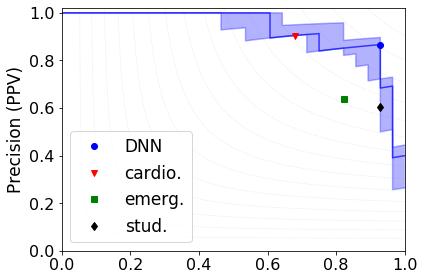

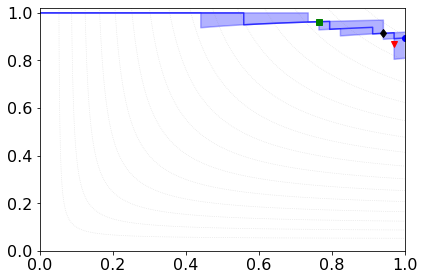

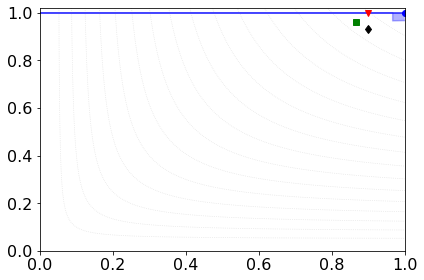

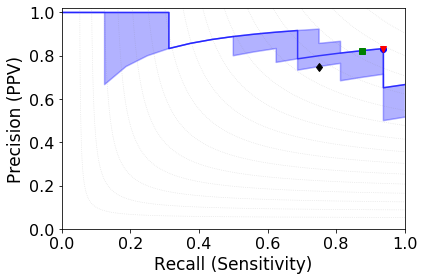

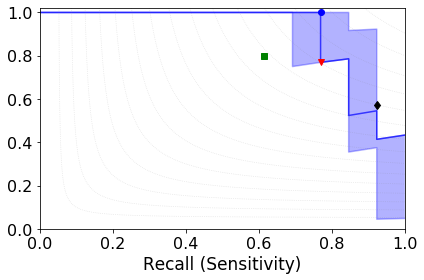

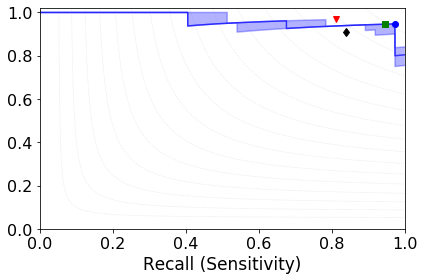

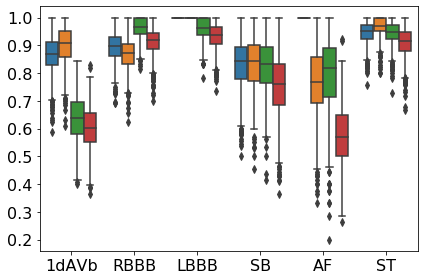

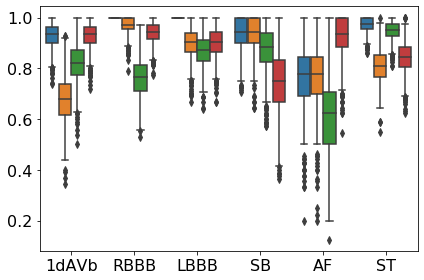

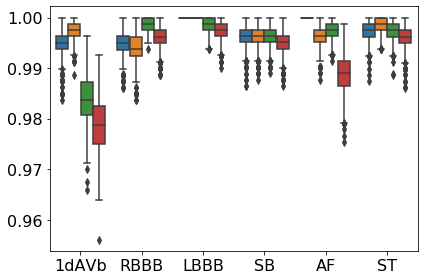

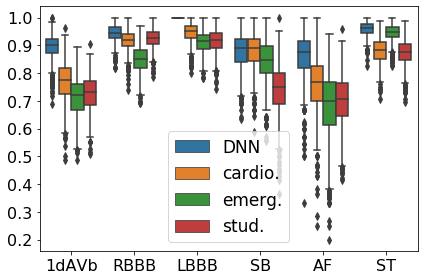

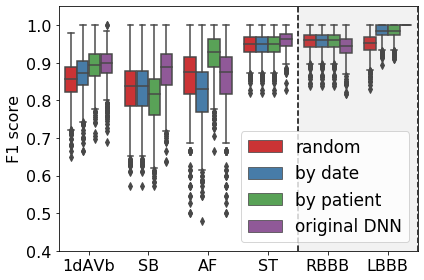

In [28]:
# %% Import packages
import pandas as pd
import numpy as np
from sklearn.metrics import (confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats.distributions import chi2
from itertools import combinations

# %% Auxiliar functions
def get_scores(y_true, y_pred, score_fun):
    nclasses = np.shape(y_true)[1]
    scores = []
    for name, fun in score_fun.items():
        scores += [[fun(y_true[:, k], y_pred[:, k]) for k in range(nclasses)]]
    return np.array(scores).T


def specificity_score(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    spc = m[0, 0] * 1.0 / (m[0, 0] + m[0, 1])
    return spc


def get_optimal_precision_recall(y_true, y_score):
    """Find precision and recall values that maximize f1 score."""
    n = np.shape(y_true)[1]
    opt_precision = []
    opt_recall = []
    opt_threshold = []
    for k in range(n):
        # Get precision-recall curve
        precision, recall, threshold = precision_recall_curve(y_true[:, k], y_score[:, k])
        # Compute f1 score for each point (use nan_to_num to avoid nans messing up the results)
        f1_score = np.nan_to_num(2 * precision * recall / (precision + recall))
        # Select threshold that maximize f1 score
        index = np.argmax(f1_score)
        opt_precision.append(precision[index])
        opt_recall.append(recall[index])
        t = threshold[index-1] if index != 0 else threshold[0]-1e-10
        opt_threshold.append(t)
    return np.array(opt_precision), np.array(opt_recall), np.array(opt_threshold)

def affer_results(y_true, y_pred):
    """Return true positives, false positives, true negatives, false negatives.

    Parameters
    ----------
    y_true : ndarray
        True value
    y_pred : ndarray
        Predicted value

    Returns
    -------
    tn, tp, fn, fp: ndarray
        Boolean matrices containing true negatives, true positives, false negatives and false positives.
    cm : ndarray
        Matrix containing: 0 - true negative, 1 - true positive,
        2 - false negative, and 3 - false positive.
    """

    # True negative
    tn = (y_true == y_pred) & (y_pred == 0)
    # True positive
    tp = (y_true == y_pred) & (y_pred == 1)
    # False positive
    fp = (y_true != y_pred) & (y_pred == 1)
    # False negative
    fn = (y_true != y_pred) & (y_pred == 0)

    # Generate matrix of "tp, fp, tn, fn"
    m, n = np.shape(y_true)
    cm = np.zeros((m, n), dtype=int)
    cm[tn] = 0
    cm[tp] = 1
    cm[fn] = 2
    cm[fp] = 3
    return tn, tp, fn, fp, cm


# %% Constants
score_fun = {'Precision': precision_score,
             'Recall': recall_score, 'Specificity': specificity_score,
             'F1 score': f1_score}
diagnosis = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']
nclasses = len(diagnosis)
predictor_names = ['DNN', 'cardio.', 'emerg.', 'stud.']

# %% Read datasets
# Get two annotators
y_cardiologist1 = pd.read_csv('PFE/automatic-ecg-diagnosis-master/data/annotations/cardiologist1.csv').values
y_cardiologist2 = pd.read_csv('PFE/automatic-ecg-diagnosis-master/data/annotations/cardiologist2.csv').values
# Get true values
y_true = pd.read_csv('PFE/automatic-ecg-diagnosis-master/data/annotations/gold_standard.csv').values
# Get residents and students performance
y_cardio = pd.read_csv('PFE/automatic-ecg-diagnosis-master/data/annotations/cardiology_residents.csv').values
y_emerg = pd.read_csv('PFE/automatic-ecg-diagnosis-master/data/annotations/emergency_residents.csv').values
y_student = pd.read_csv('PFE/automatic-ecg-diagnosis-master/data/annotations/medical_students.csv').values
# get y_score for different models
y_score_list = [np.load('PFE/automatic-ecg-diagnosis-master/dnn_predicts/other_seeds/model_' + str(i+1) + '.npy') for i in range(10)]


# %% Get average model model
# Get micro average precision
micro_avg_precision = [average_precision_score(y_true[:, :6], y_score[:, :6], average='micro')
                           for y_score in y_score_list]
# get ordered index
index = np.argsort(micro_avg_precision)
print('Micro average precision')
print(np.array(micro_avg_precision)[index])
# get 6th best model (immediatly above median) out 10 different models
k_dnn_best = index[5]
y_score_best = y_score_list[k_dnn_best]
# Get threshold that yield the best precision recall
_, _, threshold = get_optimal_precision_recall(y_true, y_score_best)
mask = y_score_best > threshold
# Get neural network prediction
# This data was also saved in './data/csv_files/dnn.csv'
y_neuralnet = np.zeros_like(y_score_best)
y_neuralnet[mask] = 1
y_neuralnet[mask] = 1


# %% Generate table with scores for the average model (Table 2)
scores_list = []
for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]:
    # Compute scores
    scores = get_scores(y_true, y_pred, score_fun)
    # Put them into a data frame
    scores_df = pd.DataFrame(scores, index=diagnosis, columns=score_fun.keys())
    # Append
    scores_list.append(scores_df)
# Concatenate dataframes
scores_all_df = pd.concat(scores_list, axis=1, keys=['DNN', 'cardio.', 'emerg.', 'stud.'])
# Change multiindex levels
scores_all_df = scores_all_df.swaplevel(0, 1, axis=1)
scores_all_df = scores_all_df.reindex(level=0, columns=score_fun.keys())
# Save results
scores_all_df.to_excel("PFE/automatic-ecg-diagnosis-master/outputs/tables/scores.xlsx", float_format='%.3f')
scores_all_df.to_csv("PFE/automatic-ecg-diagnosis-master/outputs/tables/scores.csv", float_format='%.3f')


# %% Plot precision recall curves (Figure 2)
for k, name in enumerate(diagnosis):
    precision_list = []
    recall_list = []
    threshold_list = []
    average_precision_list = []
    fig, ax = plt.subplots()
    lw = 2
    t = ['bo', 'rv', 'gs', 'kd']
    for j, y_score in enumerate(y_score_list):
        # Get precision-recall curve
        precision, recall, threshold = precision_recall_curve(y_true[:, k], y_score[:, k])
        recall[np.isnan(recall)] = 0  # change nans to 0
        precision[np.isnan(precision)] = 0  # change nans to 0
        # Plot if is the choosen option
        if j == k_dnn_best:
            ax.plot(recall, precision, color='blue', alpha=0.7)
        # Compute average precision
        average_precision = average_precision_score(y_true[:, k], y_score[:, k])
        precision_list += [precision]
        recall_list += [recall]
        average_precision_list += [average_precision]
        threshold_list += [threshold]
    # Plot shaded region containing maximum and minimun from other executions
    recall_all = np.concatenate(recall_list)
    recall_all = np.sort(recall_all)  # sort
    recall_all = np.unique(recall_all)  # remove repeated entries
    recall_vec = []
    precision_min = []
    precision_max = []
    for r in recall_all:
        p_max = [max(precision[recall == r]) for recall, precision in zip(recall_list, precision_list)]
        p_min = [min(precision[recall == r]) for recall, precision in zip(recall_list, precision_list)]
        recall_vec += [r, r]
        precision_min += [min(p_max), min(p_min)]
        precision_max += [max(p_max), max(p_min)]
    ax.plot(recall_vec, precision_min, color='blue', alpha=0.3)
    ax.plot(recall_vec, precision_max, color='blue', alpha=0.3)
    ax.fill_between(recall_vec, precision_min, precision_max,
                    facecolor="blue", alpha=0.3)
    # Plot iso-f1 curves
    f_scores = np.linspace(0.1, 0.95, num=15)
    for f_score in f_scores:
        x = np.linspace(0.0000001, 1, 1000)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y >= 0], y[y >= 0], color='gray', ls=':', lw=0.7, alpha=0.25)
    # Plot values in
    for npred in range(4):
        ax.plot(scores_list[npred]['Recall'][k], scores_list[npred]['Precision'][k],
                t[npred], label=predictor_names[npred])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.02])
    if k in [3, 4, 5]:
        ax.set_xlabel('Recall (Sensitivity)', fontsize=17)
    if k in [0, 3]:
        ax.set_ylabel('Precision (PPV)', fontsize=17)
    # plt.title('Precision-Recall curve (' + name + ')')
    if k == 0:
        plt.legend(loc="lower left", fontsize=17)
    else:
        ax.legend().remove()
    plt.tight_layout()
    plt.savefig('PFE/automatic-ecg-diagnosis-master/outputs/figures/precision_recall_{0}.pdf'.format(name))

# %% Confusion matrices (Supplementary Table 1)

M = [[confusion_matrix(y_true[:, k], y_pred[:, k], labels=[0, 1])
      for k in range(nclasses)] for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]]

M_xarray = xr.DataArray(np.array(M),
                        dims=['predictor', 'diagnosis', 'true label', 'predicted label'],
                        coords={'predictor': ['DNN', 'cardio.', 'emerg.', 'stud.'],
                                'diagnosis': diagnosis,
                                'true label': ['not present', 'present'],
                                'predicted label': ['not present', 'present']})
confusion_matrices = M_xarray.to_dataframe('n')
confusion_matrices = confusion_matrices.reorder_levels([1, 2, 3, 0], axis=0)
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices['n']
confusion_matrices.to_excel("PFE/automatic-ecg-diagnosis-master/outputs/tables/confusion matrices.xlsx", float_format='%.3f')
confusion_matrices.to_csv("PFE/automatic-ecg-diagnosis-master/outputs/tables/confusion matrices.csv", float_format='%.3f')


#%% Compute scores and bootstraped version of these scores

bootstrap_nsamples = 1000
percentiles = [2.5, 97.5]
scores_resampled_list = []
scores_percentiles_list = []
for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]:
    # Compute bootstraped samples
    np.random.seed(123)  # NEVER change this =P
    n, _ = np.shape(y_true)
    samples = np.random.randint(n, size=n * bootstrap_nsamples)
    # Get samples
    y_true_resampled = np.reshape(y_true[samples, :], (bootstrap_nsamples, n, nclasses))
    y_doctors_resampled = np.reshape(y_pred[samples, :], (bootstrap_nsamples, n, nclasses))
    # Apply functions
    scores_resampled = np.array([get_scores(y_true_resampled[i, :, :], y_doctors_resampled[i, :, :], score_fun)
                                 for i in range(bootstrap_nsamples)])
    # Sort scores
    scores_resampled.sort(axis=0)
    # Append
    scores_resampled_list.append(scores_resampled)

    # Compute percentiles index
    i = [int(p / 100.0 * bootstrap_nsamples) for p in percentiles]
    # Get percentiles
    scores_percentiles = scores_resampled[i, :, :]
    # Convert percentiles to a dataframe
    scores_percentiles_df = pd.concat([pd.DataFrame(x, index=diagnosis, columns=score_fun.keys())
                                       for x in scores_percentiles], keys=['p1', 'p2'], axis=1)
    # Change multiindex levels
    scores_percentiles_df = scores_percentiles_df.swaplevel(0, 1, axis=1)
    scores_percentiles_df = scores_percentiles_df.reindex(level=0, columns=score_fun.keys())
    # Append
    scores_percentiles_list.append(scores_percentiles_df)
# Concatenate dataframes
scores_percentiles_all_df = pd.concat(scores_percentiles_list, axis=1, keys=predictor_names)
# Change multiindex levels
scores_percentiles_all_df = scores_percentiles_all_df.reorder_levels([1, 0, 2], axis=1)
scores_percentiles_all_df = scores_percentiles_all_df.reindex(level=0, columns=score_fun.keys())


#%% Print box plot (Supplementary Figure 1)
# Convert to xarray
scores_resampled_xr = xr.DataArray(np.array(scores_resampled_list),
                                   dims=['predictor', 'n', 'diagnosis', 'score_fun'],
                                   coords={
                                    'predictor': predictor_names,
                                    'n': range(bootstrap_nsamples),
                                    'diagnosis': ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST'],
                                    'score_fun': list(score_fun.keys())})
# Remove everything except f1_score
for sf in score_fun:
    fig, ax = plt.subplots()
    f1_score_resampled_xr = scores_resampled_xr.sel(score_fun=sf)
    # Convert to dataframe
    f1_score_resampled_df = f1_score_resampled_xr.to_dataframe(name=sf).reset_index(level=[0, 1, 2])
    # Plot seaborn
    ax = sns.boxplot(x="diagnosis", y=sf, hue="predictor", data=f1_score_resampled_df)
    # Save results
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("")
    plt.ylabel("", fontsize=16)
    if sf == "F1 score":
        plt.legend(fontsize=17)
    else:
        ax.legend().remove()
    plt.tight_layout()
    plt.savefig('PFE/automatic-ecg-diagnosis-master/outputs/figures/boxplot_bootstrap_{}.pdf'.format(sf))


scores_resampled_xr.to_dataframe(name='score').to_csv('PFE/automatic-ecg-diagnosis-master/outputs/figures/boxplot_bootstrap_data.txt')

#%% McNemar test  (Supplementary Table 3)
# Get correct and wrong predictions for each of them (cm >= 2 correspond to wrong predictions)
wrong_predictions = np.array([affer_results(y_true, y_pred)[4] >= 2
                              for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]])

# Compute McNemar score
names = ["DNN", "cardio.", "emerg.", "stud."]
mcnemar_name = []
mcnemar_score = np.empty((6, 6))
k = 0
for i in range(4):
    for j in range(i+1, 4):
        a_not_b = np.sum(wrong_predictions[i, :, :] & ~wrong_predictions[j, :, :], axis=0)
        b_not_a = np.sum(~wrong_predictions[i, :, :] & wrong_predictions[j, :, :], axis=0)
        # An alterantive to the standard McNemar test is to include a
        # continuity correction term, resulting in:
        # mcnemar_corr_score = np.square(np.abs(a_not_b - b_not_a) - 1) / (a_not_b + b_not_a)
        # I tested both and came the conclusion, that we cannot reject the null hypotesis
        # for neither. The standard test however provide results that are easier to visualize.
        mcnemar_score[k, :] = np.square(a_not_b - b_not_a) / (a_not_b + b_not_a)
        k += 1
        mcnemar_name += [names[i] + " vs " + names[j]]

mcnemar = pd.DataFrame(1-chi2.cdf(mcnemar_score, 1), index=mcnemar_name, columns=diagnosis) # p-value

# Save results
mcnemar.to_excel("PFE/automatic-ecg-diagnosis-master/outputs/tables/mcnemar.xlsx", float_format='%.3f')
mcnemar.to_csv("PFE/automatic-ecg-diagnosis-master/outputs/tables/mcnemar.csv", float_format='%.3f')

# %% Kappa score classifiers (Supplementary Table 2(a))

names = ["DNN", "cardio.", "emerg.", "stud."]
predictors = [y_neuralnet, y_cardio, y_emerg, y_student]
kappa_name = []
kappa_score = np.empty((6, 6))
k = 0
for i in range(4):
    for j in range(i+1, 4):
        y_pred_1 = predictors[i]
        y_pred_2 = predictors[j]
        # Get "confusion matrix"
        negative_negative, positive_positive, positive_negative, negative_positive, _ = \
            affer_results(y_pred_1, y_pred_2)
        p_p = positive_positive.sum(axis=0)
        p_n = positive_negative.sum(axis=0)
        n_p = negative_positive.sum(axis=0)
        n_n = negative_negative.sum(axis=0)
        total_sum = p_p + p_n + n_p + n_n
        # Relative agreement
        r_agree = (p_p + n_n) / total_sum
        # Empirical probability of both saying yes
        p_yes = (p_p + p_n) * (p_p + n_p) / total_sum**2
        # Empirical probability of both saying no
        p_no = (n_n + n_p) * (n_n + p_n) / total_sum**2
        # Empirical probability of agreement
        p_agree = p_yes + p_no
        # Kappa score
        kappa_score[k, :] = (r_agree - p_agree) / (1 - p_agree)
        k += 1
        kappa_name += [names[i] + " vs " + names[j]]

kappa = pd.DataFrame(kappa_score, index=kappa_name, columns=diagnosis)  # p-value

# Save results
kappa.to_excel("PFE/automatic-ecg-diagnosis-master/outputs/tables/kappa.xlsx", float_format='%.3f')
kappa.to_csv("PFE/automatic-ecg-diagnosis-master/outputs/tables/kappa.csv", float_format='%.3f')


# %% Kappa score dataset generation (Supplementary Table 2(b))

# Compute kappa score
kappa_list = []
names_list = []
raters = [('DNN', y_neuralnet), ('Cert. cardiol. 1', y_cardiologist1), ('Certif. cardiol. 2', y_cardiologist2)]
for r1, r2 in combinations(raters, 2):
    name1, y1 = r1
    name2, y2 = r2
    negative_negative, positive_positive, positive_negative, negative_positive, _ = \
        affer_results(y1, y2)
    p_p = positive_positive.sum(axis=0)
    p_n = positive_negative.sum(axis=0)
    n_p = negative_positive.sum(axis=0)
    n_n = negative_negative.sum(axis=0)
    total_sum = p_p + p_n + n_p + n_n
    # Relative agreement
    r_agree = (p_p + n_n) / total_sum
    # Empirical probability of both saying yes
    p_yes = (p_p + p_n) * (p_p + n_p) / total_sum ** 2
    # Empirical probability of both saying no
    p_no = (n_n + n_p) * (n_n + p_n) / total_sum ** 2
    # Empirical probability of agreement
    p_agree = p_yes + p_no
    # Kappa score
    kappa = (r_agree - p_agree) / (1 - p_agree)
    kappa_list.append(kappa)
    names_list.append('{} vs {}'.format(name1, name2))

kappas_annotators_and_DNN = pd.DataFrame(np.stack(kappa_list), columns=diagnosis, index=names_list)
print(kappas_annotators_and_DNN)
kappas_annotators_and_DNN.to_excel("PFE/automatic-ecg-diagnosis-master/outputs/tables/kappas_annotators_and_DNN.xlsx", float_format='%.3f')
kappas_annotators_and_DNN.to_csv("PFE/automatic-ecg-diagnosis-master/outputs/tables/kappas_annotators_and_DNN.csv", float_format='%.3f')

# %% Compute scores and bootstraped version of these scores on alternative splits
bootstrap_nsamples = 1000
scores_resampled_list = []
scores_percentiles_list = []
for name in ['normal_order', 'date_order', 'individual_patients', 'base_model']:
    print(name)
    # Get data
    yn_true = y_true
    yn_score = np.load('PFE/automatic-ecg-diagnosis-master/dnn_predicts/other_splits/model_'+name+'.npy') if not name == 'base_model' else y_score_best
    # Compute threshold
    nclasses = np.shape(yn_true)[1]
    opt_precision, opt_recall, threshold = get_optimal_precision_recall(yn_true, yn_score)
    mask_n = yn_score > threshold
    yn_pred = np.zeros_like(yn_score)
    yn_pred[mask_n] = 1
    # Compute bootstraped samples
    np.random.seed(123)  # NEVER change this =P
    n, _ = np.shape(yn_true)
    samples = np.random.randint(n, size=n * bootstrap_nsamples)
    # Get samples
    y_true_resampled = np.reshape(yn_true[samples, :], (bootstrap_nsamples, n, nclasses))
    y_doctors_resampled = np.reshape(yn_pred[samples, :], (bootstrap_nsamples, n, nclasses))
    # Apply functions
    scores_resampled = np.array([get_scores(y_true_resampled[i, :, :], y_doctors_resampled[i, :, :], score_fun)
                                 for i in range(bootstrap_nsamples)])
    # Sort scores
    scores_resampled.sort(axis=0)
    # Append
    scores_resampled_list.append(scores_resampled)

    # Compute percentiles index
    i = [int(p / 100.0 * bootstrap_nsamples) for p in percentiles]
    # Get percentiles
    scores_percentiles = scores_resampled[i, :, :]
    # Convert percentiles to a dataframe
    scores_percentiles_df = pd.concat([pd.DataFrame(x, index=diagnosis, columns=score_fun.keys())
                                       for x in scores_percentiles], keys=['p1', 'p2'], axis=1)
    # Change multiindex levels
    scores_percentiles_df = scores_percentiles_df.swaplevel(0, 1, axis=1)
    scores_percentiles_df = scores_percentiles_df.reindex(level=0, columns=score_fun.keys())
    # Append
    scores_percentiles_list.append(scores_percentiles_df)

# %% Print box plot on alternative splits (Supplementary Figure 2 (a))
scores_resampled_xr = xr.DataArray(np.array(scores_resampled_list),
                                   dims=['predictor', 'n', 'diagnosis', 'score_fun'],
                                   coords={
                                    'predictor': ['random', 'by date', 'by patient', 'original DNN'],
                                    'n': range(bootstrap_nsamples),
                                    'diagnosis': ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST'],
                                    'score_fun': list(score_fun.keys())})
# Remove everything except f1_score
sf = 'F1 score'
fig, ax = plt.subplots()
f1_score_resampled_xr = scores_resampled_xr.sel(score_fun=sf)
# Convert to dataframe
f1_score_resampled_df = f1_score_resampled_xr.to_dataframe(name=sf).reset_index(level=[0, 1, 2])
# Plot seaborn
ax = sns.boxplot(x="diagnosis", y=sf, hue="predictor", data=f1_score_resampled_df,
                 order=['1dAVb', 'SB', 'AF', 'ST', 'RBBB', 'LBBB'],
                 palette=sns.color_palette("Set1", n_colors=8))
plt.axvline(3.5, color='black', ls='--')
plt.axvline(5.5, color='black', ls='--')
plt.axvspan(3.5, 5.5, alpha=0.1, color='gray')
# Save results
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("")
plt.ylabel("F1 score", fontsize=16)
plt.legend(fontsize=17)
plt.ylim([0.4, 1.05])
plt.xlim([-0.5, 5.5])
plt.tight_layout()
plt.savefig('PFE/automatic-ecg-diagnosis-master/outputs/figures/boxplot_bootstrap_other_splits_{0}.pdf'.format(sf))
f1_score_resampled_df.to_csv('PFE/automatic-ecg-diagnosis-master/outputs/figures/boxplot_bootstrap_other_splits_data.txt', index=False)
print(y_pred)

## 6 - Résultats :

Les résultats de notre réseau neurones comparés aux étudiants et aux cardiologues sont les suivants :
![alt text](Res.png "DNN")

Le tableau suivant montre les performances du DNN sur le test set. On remarque qu’on obtient des résultats de haute performance pour les six anomalies avec un score F1 supérieurs à 80% et des indices de spécificité supérieurs à 99%.
Le tableau suivant montre les performances du DNN sur le test set. On remarque qu’on obtient des résultats de haute performance pour les six anomalies avec un score F1 supérieurs à 80% et des indices de spécificité supérieurs à 99%
On remarque aussi que les résultats du DNN surclasse les résultats des médecins résidents en cardiologie ainsi que les résultats des étudiants.